# MSDS 7331 - Case Study 2 - Diabetes Prediction
Daniel Crouthamel  
Sophia Wu  
Fabio Savorgnan  
Bo Yun

## Introduction
In this study, we will do XXX

1. Business Understanding
2. Data Evaluation / Engineering
3. Modeling Preparations
4. Model Building & Evaluation
5. Model Interpretability & Explainability
6. Case Conclusions

In [1]:
#importing libraries and reading in file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#general sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

#logistic regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline



## Business Understanding

Your case study is to build a classifier using logistic regression to predict hospital readmittance. There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

You should always state the objective at the beginning of every case (a guideline you should follow in real life as well) and provide some initial "Business Understanding" statements (i.e., what is trying to be solved for and why might it be important)


## Data Evaluation and Engineering

Summarize the data being used in the case using appropriate mediums (charts, graphs, tables); address questions such as: Are there missing values? Which variables are needed (which ones are not)? What assumptions or conclusions are you drawing that need to be relayed to your audience?

In [2]:
df = pd.read_csv('data/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title="Diabetes Profiling Report", minimal=True)
# profile.to_file(output_file="DiabetesProfile.html")

# Remove Encounter ID, Patient NUBR (unique ids, not needed)
# Race -> What are we doing with ? -> What's are final decision on imputing race?
# Age -> Bin like in Fabios Code
# Weight -> Remove, too many unknowns
# Admission ID Type -> Merging values 5, 8 into 6 (see mapping spreadsheet)
# Admission Source -> Merging values 9, 15, 20, 21 into 17
# Discharge disposition -> remove observations where the discharge disposition is related to hospice or death since these will not add to the possibility of being readmitted (see Fabio's code)
# DX -> Bin using updated function, reference paper
# Remove Payor Code - not helpful
# Remove Medical speciality - not helpful
# max_glu_serum - Keeping None
# A1Cresult - Keeping None
# For the remainder Categorical variables we will keep the none buckets, except examide and citoglipton since they only have one value
# Numerical features, some are normally distrbuted, others aren't but we will use RobustScaler
# Readmitted -> Convert to binary as done in document, Fabio's code

In [4]:
df_reduced= df.drop(columns=['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty', 'examide', 'citoglipton'])

### Categorizing Diagnoses Codes

Explanation:

In [5]:
# Function to Categorize DX based on URL ...
def bin_dx(code):
    try:
        code = float(code)
    except:
        code = 0

    # Circulatory
    if code in range(390,460) or code == 785:
        return("Circulatory")

    # Respiratory
    elif code in range(460,520) or code == 786:
        return("Respiratory")

    # Digestive
    elif code in range(520,580) or code == 787:
        return("Digestive")

    # Diabetes
    elif code >= 250 and code < 251:
        return("Diabetes")

    # Injury
    elif code in range(800,1000):
        return("Injury")

    # Musculoskeletal
    elif code in range(710,740):
        return("Musculoskeletal")

    # Genitourinary
    elif code in range(580,630) or code == 788:
        return("Genitourinary")

    # Neoplasms
    elif code in range(140,240):
        return("Neoplasms")
    elif code in range(780,783) or code == 784:
        return("Neoplasms")
    elif code in range(790,800):
        return("Neoplasms")
    elif code in range(240,250):
        return("Neoplasms")
    elif code in range(251,280):
        return("Neoplasms")
    elif code in range(680,710):
        return("Neoplasms")
    elif code in range(1,140):
        return("Neoplasms")
    elif code in range(290,320):
        return("Neoplasms")

    # Other
    else:
        return("Other")

In [6]:
df_reduced["Diag1"] = df_reduced["diag_1"].apply(bin_dx)
df_reduced["Diag2"] = df_reduced["diag_2"].apply(bin_dx)
df_reduced["Diag3"] = df_reduced["diag_3"].apply(bin_dx)


print(df_reduced["Diag1"].value_counts())
print("")
print(df_reduced["Diag2"].value_counts())
print("")
print(df_reduced["Diag3"].value_counts())

Circulatory        30437
Neoplasms          16318
Respiratory        14423
Digestive           9475
Diabetes            8757
Injury              6974
Other               5308
Genitourinary       5117
Musculoskeletal     4957
Name: Diag1, dtype: int64

Circulatory        31881
Neoplasms          21462
Diabetes           12794
Respiratory        10895
Genitourinary       8376
Other               7996
Digestive           4170
Injury              2428
Musculoskeletal     1764
Name: Diag2, dtype: int64

Circulatory        30306
Neoplasms          20985
Diabetes           17157
Other              11489
Respiratory         7358
Genitourinary       6680
Digestive           3930
Injury              1946
Musculoskeletal     1915
Name: Diag3, dtype: int64


In [7]:
df_reduced = df_reduced.drop(columns=['diag_1', 'diag_2', 'diag_3'])

### Categorize Age

In [8]:
print(df_reduced["age"].value_counts())
di = {'[70-80)': 'Old', '[60-70)': 'Old', '[80-90)': 'Old', '[90-100)': 'Old', '[50-60)': 'Midage', '[40-50)': 'Midage', '[30-40)': 'Young', '[20-30)': 'Young', '[10-20)': 'Young', '[0-10)': 'Young'}

df_reduced["age"].replace(di, inplace=True)
print(df_reduced["age"].value_counts())


[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64
Old       68541
Midage    26941
Young      6284
Name: age, dtype: int64


### Discharge Disposition

Describe what is done

In [9]:
print(df_reduced['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64


In [10]:
indexNames = df_reduced[df_reduced['discharge_disposition_id'].isin([11,13,14,19,20,21])].index
df_reduced.drop(indexNames, inplace=True)

print(df_reduced['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
5      1184
25      989
4       815
7       623
23      412
28      139
8       108
15       63
24       48
9        21
17       14
16       11
10        6
27        5
12        3
Name: discharge_disposition_id, dtype: int64


### Admission Source and ID type

In [11]:
# reagenge the id coluns can be useful in a way that all the missing values is place in one place and make it categorical
# admission_type_id
df_reduced.admission_type_id.replace(to_replace = 5, value = 6, inplace = True)
df_reduced.admission_type_id.replace(to_replace = 8, value = 6, inplace = True)
df_reduced.admission_type_id = df_reduced.admission_type_id.astype(str)

# admission_source_id
df_reduced.admission_source_id.replace(to_replace = 9, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 15, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 20, value = 17, inplace = True)
df_reduced.admission_source_id.replace(to_replace = 21, value = 17, inplace = True)
df_reduced.admission_source_id= df_reduced.admission_source_id.astype(str)

In [12]:
print(df_reduced['admission_type_id'].value_counts())
print("")
print(df_reduced['admission_source_id'].value_counts())

1    52371
3    18668
2    18132
6    10144
7       18
4       10
Name: admission_type_id, dtype: int64

7     55850
1     29168
17     6854
4      3118
6      2239
2      1081
5       806
3       185
8        15
22       12
10        8
11        2
25        2
14        2
13        1
Name: admission_source_id, dtype: int64


### Response Variable



In [13]:
print(df_reduced['readmitted'].value_counts())

NO     52527
>30    35502
<30    11314
Name: readmitted, dtype: int64


In [14]:
di = {'NO': 0, '>30': 0, '<30': 1}

df_reduced["readmitted"].replace(di, inplace=True)
print(df_reduced["readmitted"].value_counts())

0    88029
1    11314
Name: readmitted, dtype: int64


In [15]:
categorical_features = ['race', 'gender', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide','chlorpropamide',
                        'glimepiride', 'acetohexamide', 'glipizide','glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 
                        'acarbose','miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
                        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed',
                        'Diag1', 'Diag2','Diag3', 'age', 'admission_type_id', 'discharge_disposition_id','admission_source_id']

numeric_features = ['time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 'number_outpatient', 
                    'number_emergency', 'number_inpatient', 'number_diagnoses']

X = df_reduced[categorical_features + numeric_features]
y = df_reduced['readmitted']

# Verify shapes
print(df_reduced.shape)
print(X.shape)
print(y.shape)

(99343, 43)
(99343, 42)
(99343,)


In [16]:
# https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7

# Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ##['scaler', RobustScaler(with_centering=False)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'classifier__penalty': ['l1', 'l2']}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           #scoring=scorers,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.64223231        nan 0.63998349        nan 0.63836676
        nan 0.63746643        nan 0.63723473        nan 0.63718634
        nan 0.63715904]
  warnings.warn(


Cross-validation score: 0.6422323088311607
Test score: 0.649188283892091


In [17]:
print(grid_search.best_params_)

{'classifier__C': 0.001, 'classifier__penalty': 'l2'}


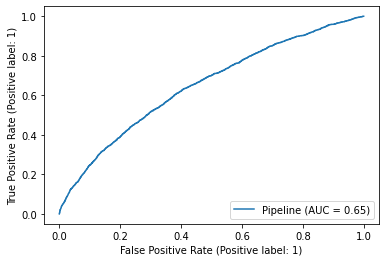

In [18]:
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

metrics.plot_roc_curve(grid_search.best_estimator_, X_test, y_test)

In [19]:
probs_y = grid_search.predict_proba(X_test)
print(probs_y)

probs_y[:,1]

[[0.65713172 0.34286828]
 [0.38967761 0.61032239]
 [0.67520265 0.32479735]
 ...
 [0.74468868 0.25531132]
 [0.63204213 0.36795787]
 [0.6083575  0.3916425 ]]


array([0.34286828, 0.61032239, 0.32479735, ..., 0.25531132, 0.36795787,
       0.3916425 ])

(0.0, 1.0)

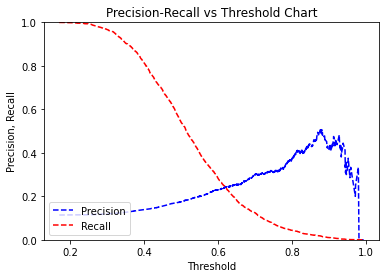

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:,1]) 

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [21]:
from sklearn.metrics import classification_report

target_names = y_test.unique().astype(str)
y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

vals = []

for val in probs_y[:,1]:
    if val > 0.4:
        vals.append(1)
    else:
        vals.append(0)

print(classification_report(y_test, vals, target_names=target_names))

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     17606
           1       0.17      0.54      0.26      2263

    accuracy                           0.66     19869
   macro avg       0.55      0.61      0.52     19869
weighted avg       0.83      0.66      0.72     19869

              precision    recall  f1-score   support

           0       0.94      0.35      0.51     17606
           1       0.14      0.81      0.24      2263

    accuracy                           0.40     19869
   macro avg       0.54      0.58      0.37     19869
weighted avg       0.85      0.40      0.48     19869



In [22]:
import eli5

onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

eli5.explain_weights(grid_search.best_estimator_.named_steps['classifier'], top=50, feature_names=numeric_features_list)

Weight?,Feature
+0.500,discharge_disposition_id_22
+0.269,number_inpatient
+0.266,A1Cresult_None
+0.219,race_Caucasian
+0.159,age_Old
+0.158,number_diagnoses
+0.155,Diag1_Circulatory
+0.142,discharge_disposition_id_5
+0.137,admission_source_id_1
+0.136,glimepiride_No
